## Validation against measure electricity production

In [1]:
from windisch import WindTurbineModel
import pandas as pd
import xarray as xr
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326", always_xy=True)

In [2]:
from windisch import __file__
__file__

'/Users/kalenajonsson/Desktop/SemesterProject/Code/windisch_folder/windisch/__init__.py'

In [ ]:
dk = pd.read_excel("danish_wind_turbine_registry.xlsx", header=13)
dk = dk.iloc[:, [3, 12, 13,] + list(range(15, 62))]
cols = [
    "Power (kW)",
    "X",
    "Y",
] + [f"Production {i}" for i in range(1977, 2024)]

dk.columns = cols


dk["Production"] = dk.loc[:,"Production 2000":].mean(skipna=True, axis=1)

dk = dk.loc[dk["Production"] > 0]
dk = dk.loc[dk["X"] > 0]
dk = dk.loc[dk["Power (kW)"] >= 100]

dk["Load factor"] = dk["Production"] / (dk["Power (kW)"] * 8760)
dk = dk.loc[(dk["Load factor"] > 0.2) & (dk["Load factor"] < 0.6)]
dk = dk.sort_values(by="Power (kW)", ascending=True)

In [3]:
# Convert X, Y to Longitude (LON) and Latitude (LAT)
def convert_to_lat_lon(row):
    if pd.notnull(row['X']) and pd.notnull(row['Y']):
        lon, lat = transformer.transform(row['X'], row['Y'])
        return pd.Series([lon, lat])
    else:
        return pd.Series([None, None])

dk[['LAT', 'LON']] = dk.apply(convert_to_lat_lon, axis=1)

In [4]:
import numpy as np
fp = "era5_mean_2013-2022_month_by_hour_corrected.nc"

def get_load_factor(row):

    tip = TurbinesInputParameters()
    tip.static()
    _, array = fill_xarray_from_input_parameters(
        tip,
        scope={"year": [2020, ],}
    )
    array = array.interp(size=[row["Power (kW)"]], kwargs={"fill_value": "extrapolate"},)
    wt = WindTurbineModel(
        array,
        location=(row["LON"], row["LAT"]),
        wind_data=xr.open_dataset(fp),
    )
    wt.set_all()

    if wt.array.sel(application="offshore", parameter="power").sum() > 0:
        is_offshore = True
    else: 
        is_offshore = False
    return [
        np.squeeze(np.nan_to_num(wt["average load factor"].values, 0)).max().item(0), 
        is_offshore
    ]

In [5]:
dk["Predicted"] = None
dk["is_offshore"] = None

rows = len(dk)
dk[["Predicted", "is_offshore"]] = pd.DataFrame(dk.iloc[:rows, :].apply(get_load_factor, axis=1).to_list(), index=dk.index[:rows])

Fetching terrain data only.
Using cached data for location (56.53188098420083, 8.442665534877477)
Onshore wind turbines
Fetching terrain data only.
Using cached data for location (56.7719421591468, 8.288364361821037)
Onshore wind turbines
Fetching terrain data only.
Using cached data for location (56.90303698512587, 9.180925483194725)
Onshore wind turbines
Fetching terrain data only.
Using cached data for location (57.03405891714653, 8.825124202050064)
Onshore wind turbines
Fetching terrain data only.
Using cached data for location (56.90187769336101, 8.607749285082702)
Onshore wind turbines
Fetching terrain data only.
Using cached data for location (56.879041584882565, 8.582949177008588)
Onshore wind turbines
Fetching terrain data only.
Using cached data for location (56.7316669024573, 8.43004723220513)
Onshore wind turbines
Fetching terrain data only.
Using cached data for location (56.670280744840966, 8.212787584093537)
Offshore wind turbines
Fetching terrain data only.
Using cached

Mean Absolute Percentage Error (MAPE), onshore: 23.65%
Mean Absolute Percentage Error (MAPE), offshore: 35.22%


<Axes: >

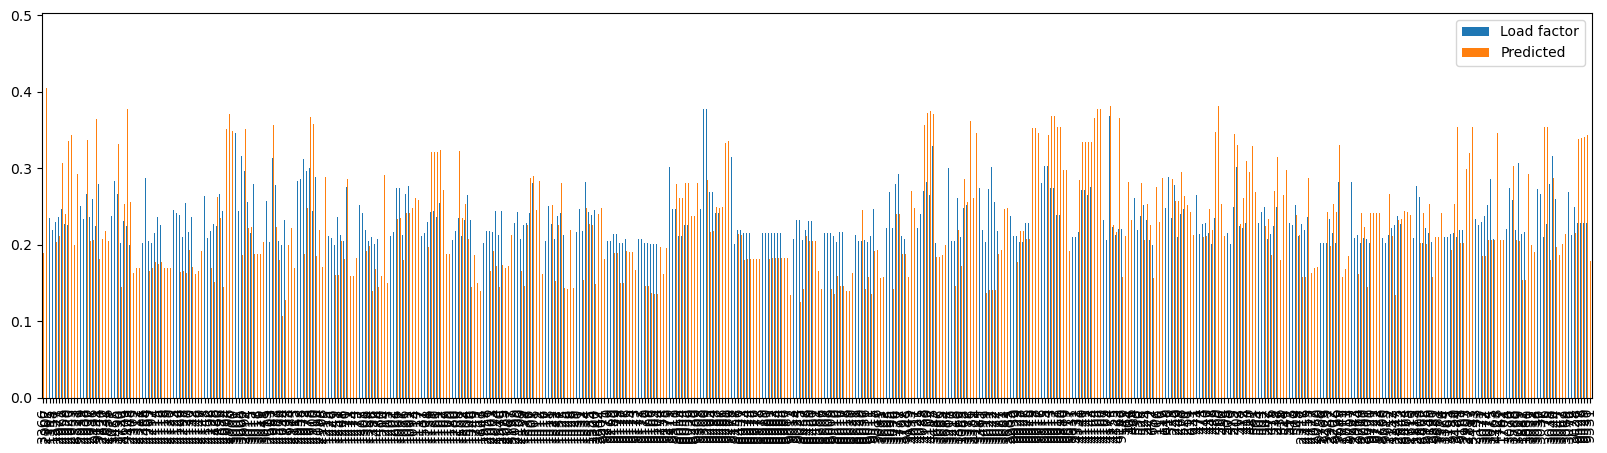

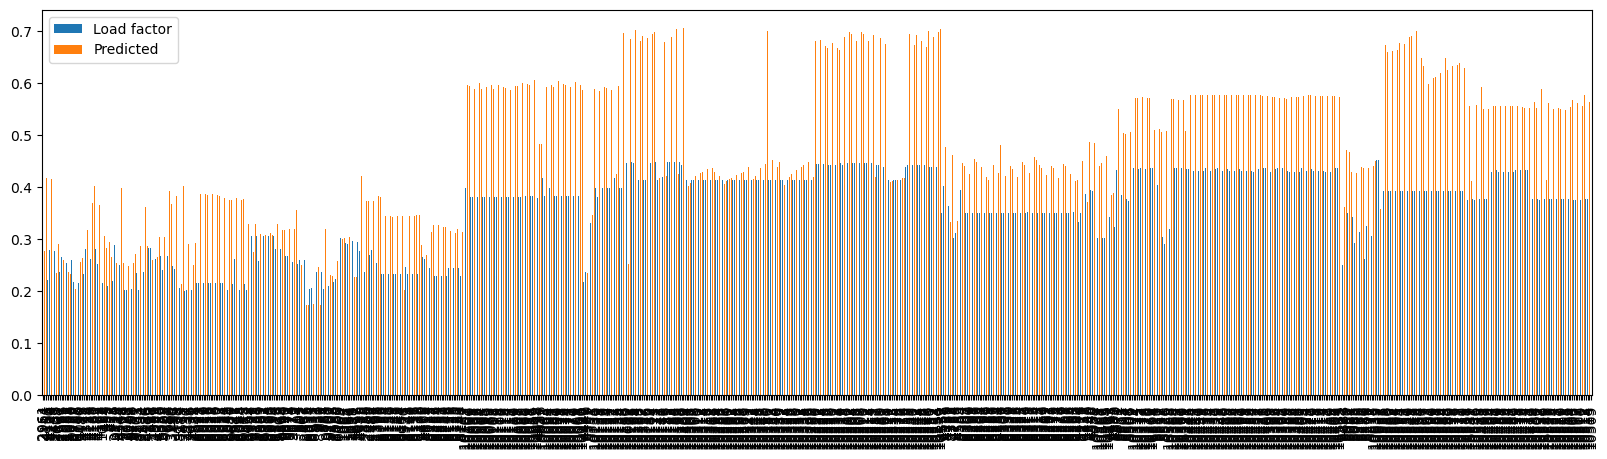

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Extract the actual and predicted load factors
actual_onshore = dk.loc[dk["is_offshore"] == False, "Load factor"]
predicted_onshore = dk.loc[dk["is_offshore"] == False, "Predicted"]

actual_offshore = dk.loc[dk["is_offshore"] == True, "Load factor"]
predicted_offshore = dk.loc[dk["is_offshore"] == True, "Predicted"]

# Drop rows where either value is NaN
mask_onshore = ~actual_onshore.isna() & ~predicted_onshore.isna() & actual_onshore > 0
actual_onshore = actual_onshore[mask_onshore]
predicted_onshore = predicted_onshore[mask_onshore]

mask_offshore = ~actual_offshore.isna() & ~predicted_offshore.isna() & actual_offshore > 0
actual_offshore = actual_offshore[mask_offshore]
predicted_offshore = predicted_offshore[mask_offshore]

# Compute metrics
#mae = mean_absolute_error(actual, predicted)
#mse = mean_squared_error(actual, predicted)
#rmse = np.sqrt(mse)
mape_onshore = np.mean(np.abs((actual_onshore - predicted_onshore) / actual_onshore)) * 100  # In percentage
mape_offshore = np.mean(np.abs((actual_offshore - predicted_offshore) / actual_offshore)) * 100  # In percentage
#r2 = r2_score(actual, predicted)

# Display the metrics
#print(f"Mean Absolute Error (MAE): {mae:.4f}")
#print(f"Mean Squared Error (MSE): {mse:.4f}")
#print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE), onshore: {mape_onshore:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE), offshore: {mape_offshore:.2f}%")
#print(f"R² (Coefficient of Determination): {r2:.4f}")
dk.loc[
    (dk["Predicted"] > 0)
    & (dk["is_offshore"] == False), 
    ["Load factor", "Predicted"]
].iloc[:500].plot(kind="bar", figsize=(20, 5))

dk.loc[
    (dk["Predicted"] > 0)
    & (dk["is_offshore"] == True), 
    ["Load factor", "Predicted"]
].plot(kind="bar", figsize=(20, 5))

/var/folders/cn/pys1j9rn0y7djkhv3hfdtrs00000gn/T/ipykernel_98707/2063013040.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Power_bin"] = pd.cut(df["Power (kW)"], bins=list(range(0, int(df["Power (kW)"].max()) + bin_width, bin_width)), right=False)
/var/folders/cn/pys1j9rn0y7djkhv3hfdtrs00000gn/T/ipykernel_98707/2063013040.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("Power_bin")


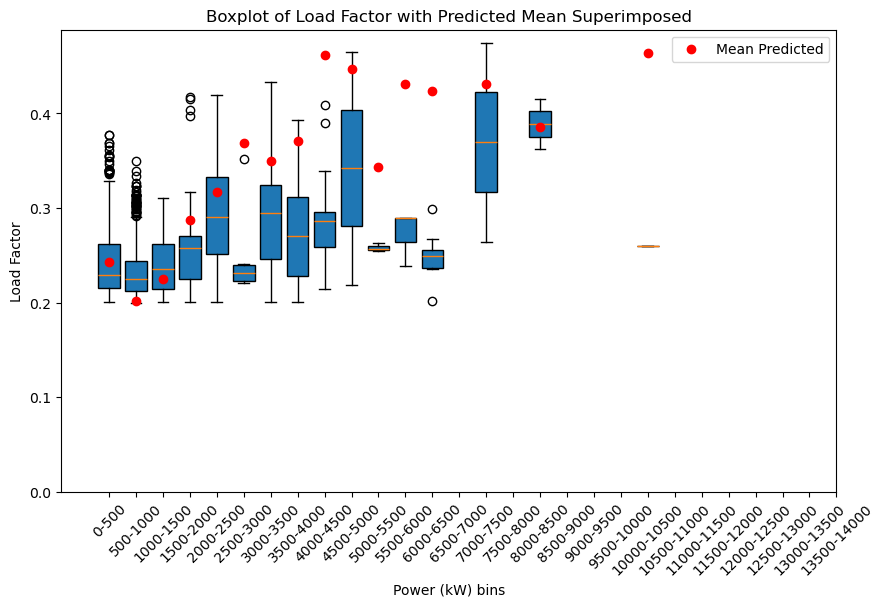

In [9]:
import matplotlib.pyplot as plt

bin_width = 500
df = dk.loc[
    (dk["Predicted"] > 0)
    & (dk["is_offshore"] == False), 
    :
]
# Adjust the binning to include 0-500 kW explicitly
df["Power_bin"] = pd.cut(df["Power (kW)"], bins=list(range(0, int(df["Power (kW)"].max()) + bin_width, bin_width)), right=False)

# Group by the new bins
grouped = df.groupby("Power_bin")
load_factor_data = [group["Load factor"].values for _, group in grouped]
predicted_means = grouped["Predicted"].mean()

# Convert bin labels to numeric for plotting
bin_labels = [f"{int(bin.left)}-{int(bin.right)}" for bin in grouped.groups.keys()]
bin_positions = [bin.left for bin in grouped.groups.keys()]

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(load_factor_data, positions=bin_positions, widths=400, patch_artist=True)

# Superimpose mean values for "Predicted"
ax.scatter(bin_positions, predicted_means.values, color='red', marker='o', label="Mean Predicted", zorder=5)

# Formatting
ax.set_xticks(bin_positions)
ax.set_xticklabels(bin_labels, rotation=45)
ax.set_xlabel("Power (kW) bins")
ax.set_ylabel("Load Factor")
ax.set_title("Boxplot of Load Factor with Predicted Mean Superimposed")
ax.legend()

ax.set_ylim(0, None)

# Show plot
plt.show()


/var/folders/cn/pys1j9rn0y7djkhv3hfdtrs00000gn/T/ipykernel_98707/3043348510.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Power_bin"] = pd.cut(df["Power (kW)"], bins=list(range(0, int(df["Power (kW)"].max()) + bin_width, bin_width)), right=False)
/var/folders/cn/pys1j9rn0y7djkhv3hfdtrs00000gn/T/ipykernel_98707/3043348510.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("Power_bin")


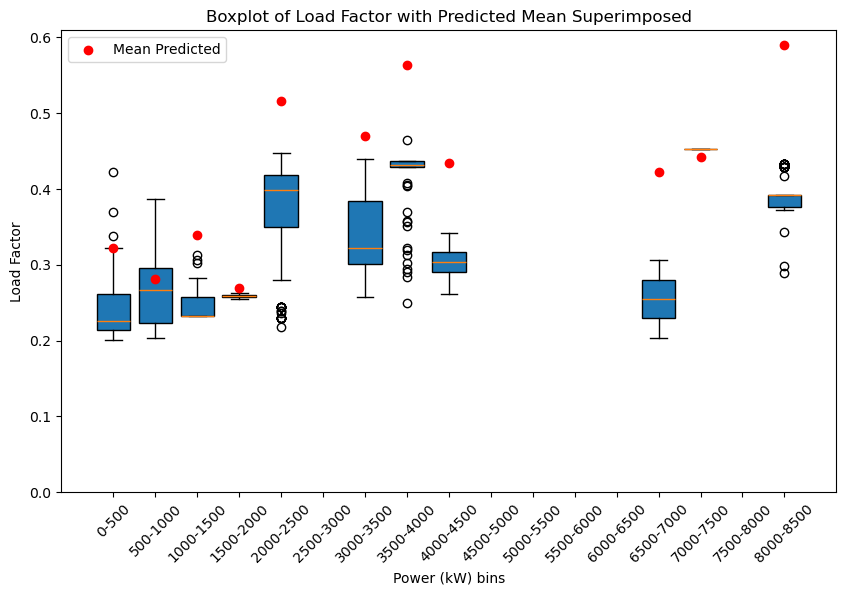

In [10]:
df = dk.loc[
    (dk["Predicted"] > 0)
    & (dk["is_offshore"] == True), 
    :
]

# Adjust the binning to include 0-500 kW explicitly
df["Power_bin"] = pd.cut(df["Power (kW)"], bins=list(range(0, int(df["Power (kW)"].max()) + bin_width, bin_width)), right=False)

# Group by the new bins
grouped = df.groupby("Power_bin")
load_factor_data = [group["Load factor"].values for _, group in grouped]
predicted_means = grouped["Predicted"].mean()

# Convert bin labels to numeric for plotting
bin_labels = [f"{int(bin.left)}-{int(bin.right)}" for bin in grouped.groups.keys()]
bin_positions = [bin.left for bin in grouped.groups.keys()]

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(load_factor_data, positions=bin_positions, widths=400, patch_artist=True)

# Superimpose mean values for "Predicted"
ax.scatter(bin_positions, predicted_means.values, color='red', marker='o', label="Mean Predicted", zorder=5)

# Formatting
ax.set_xticks(bin_positions)
ax.set_xticklabels(bin_labels, rotation=45)
ax.set_xlabel("Power (kW) bins")
ax.set_ylabel("Load Factor")
ax.set_title("Boxplot of Load Factor with Predicted Mean Superimposed")
ax.legend()

ax.set_ylim(0, None)

# Show plot
plt.show()
